In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor #or any model of your choice
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
#To get the root mean squared error
'''
rmse=mean_squared_error(y_true,y_pred,squared=False)
'''


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hackathon-qualification/sample_submission.csv
/kaggle/input/hackathon-qualification/train.csv
/kaggle/input/hackathon-qualification/test.csv


# Loading Dataset

In [2]:
try:
    train_df = pd.read_csv('/kaggle/input/hackathon-qualification/train.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: The file 'car_prices.csv' was not found. Please check the file path.")

Data loaded successfully!


# Exploratory Data Analysis

In [3]:
def plots(columns,ncols_for_subplot, df):
    ncols = ncols_for_subplot
    nrows = -(-len(columns) // ncols)  # ceiling division

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.scatterplot(x=col, y='price', data=df, ax=axes[i])
        axes[i].set_title(f'Price vs. {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Price')

    # hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [4]:
categorical_cols = train_df.select_dtypes(include='object').columns
numerical_cols = train_df.select_dtypes(exclude='object').columns
def exploratory_data_analysis(df):
    '''This function performs some preliminary EDA. You are free to add more to it to 
       guide you in preparing your dataset for trainiing
    '''
    print("First 5 rows of the dataset:")
    print(df.head())
    
    # Get information about the dataset (data types, non-null values)
    print("\nDataset information:")
    df.info()
    
    # Get descriptive statistics for numerical columns
    print("\nDescriptive statistics for numerical columns:")
    print(df.describe())
    #Get descriptive statistics for categorical columns
    print("\nDescriptive statistics for categorical columns:")
    print(df.describe(include='object'))
    #Checking for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())
    # Visualize the distribution of the target variable (price)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['price'], kde=True, bins=50)
    plt.title('Distribution of Car Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()
    
    
    # Visualizing the relationship between all numerical features and price
    # For example, 'mileage' and 'price'
    print('Plotting numerical variables vs price')
    numerical_plot=plots(numerical_cols,2,df)
   

First 5 rows of the dataset:
   id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2     

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


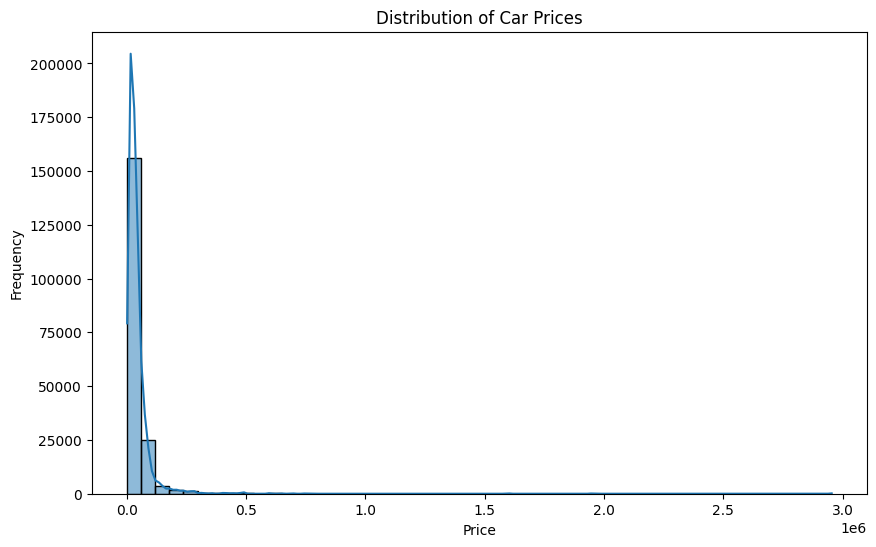

Plotting numerical variables vs price


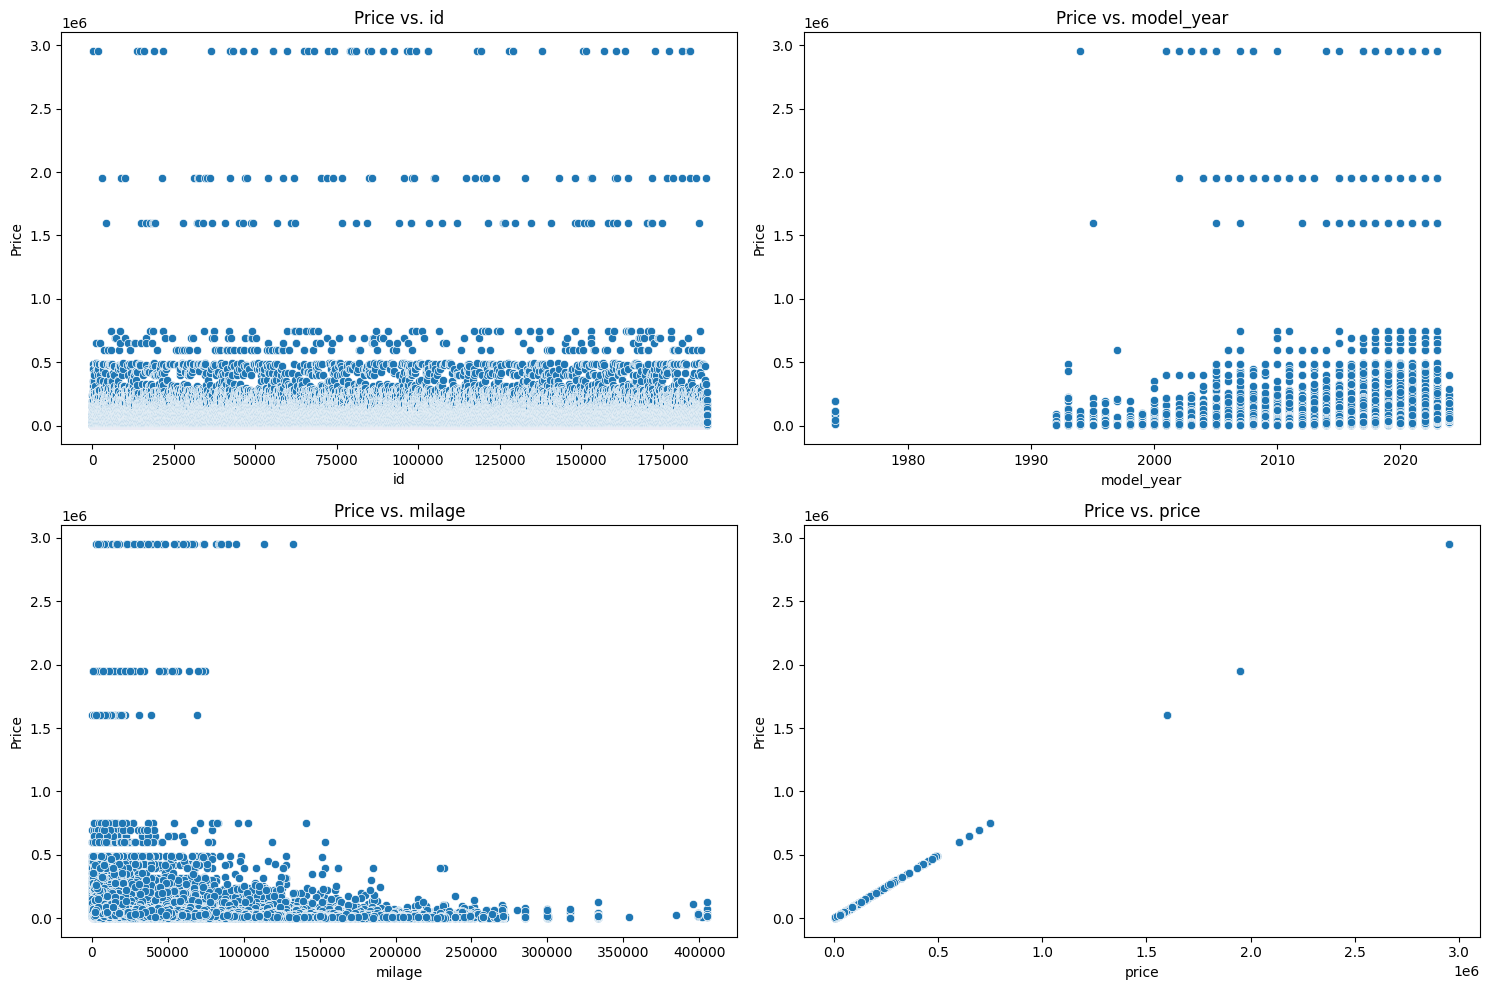

In [5]:
exploratory_data_analysis(train_df)

In [6]:
def filling_missing_values_in_numerical_columns(df):
    numerical_cols_with_missing = ['model_year', 'milage'] # Replace with your columns

    # Fill missing values using the median of each column
    for col in numerical_cols_with_missing:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
    
    print("DataFrame after filling numerical missing values:")
    print(df.info())
    return df


In [7]:
def filling_missing_values_in_categorical_columns(df):
        categorical_cols_with_missing = ['model', 'fuel_type'] # Replace with your columns
        # You could fill missing values using the mode of each column. Feel free to choose your strategy
        for col in categorical_cols_with_missing:
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
        
        print("DataFrame after filling categorical missing values:")
        print(df.info())
        return df

In [8]:

def encode_categorical_columns(df):
    le = LabelEncoder()
    
   
    #categorical_cols = df.select_dtypes(include='object').columns
    print('Encoding variables...')
    for col in categorical_cols:
        
        try:
            if df[col].isnull().any():
                # If so, fill them with a placeholder string 'missing' before encoding
                df[col].fillna('missing', inplace=True)
            
            
            df[col] = le.fit_transform(df[col])
            print(f"Successfully applied Label Encoding to: {col}")
        except Exception as e:
            print(f"Could not apply Label Encoding to {col}. Error: {e}")
    return df

In [9]:
def preprocessing(df):
    '''
    This function cleans your data for you. Feel free to tweak it to your tastes
    It comprises filling missing data, encoding categorical variables etc
    Perhaps feature engineering as well. Have fun!
    Argument:
        data (pd.DataFrame): The input DataFrame.
    
    Returns:
        pd.DataFrame: The preprocessed DataFrame.
    '''
    df=filling_missing_values_in_numerical_columns(df)
    df=filling_missing_values_in_categorical_columns(df)
    df=encode_categorical_columns(df)
    

    return df

In [10]:
df=preprocessing(train_df)

/tmp/ipykernel_36/904521727.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)
/tmp/ipykernel_36/4218426678.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

DataFrame after filling numerical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB
None
DataFrame after filling categorical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data col

/tmp/ipykernel_36/2107136911.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('missing', inplace=True)
/tmp/ipykernel_36/2107136911.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

In [11]:
X = df.drop('price', axis=1) # Replace 'price' with your target column name
y = df['price']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_val)}")


Training set size: 150826
Testing set size: 37707


In [12]:
print(X_train.head())

            id  brand  model  model_year  milage  fuel_type  engine  \
184031  184031     36    764        2017   61675          1     258   
173831  173831     39    732        2003  185000          2     323   
183819  183819     14    670        2020   92000          2     651   
85525    85525     19    583        2023    5483          2     441   
41872    41872     11    457        2023    5000          2    1093   

        transmission  ext_col  int_col  accident  clean_title  
184031            49      128       14         0            0  
173831            38      263       71         0            0  
183819             2      128       71         0            0  
85525             20       29       14         1            1  
41872             16      234       14         1            0  


# Training your Model

In [13]:
def train_with_cv(estimator, param_grid, X, y, cv_splits=5, scoring=None):
    """
    Perform K-Fold Cross Validation with hyperparameter tuning. Adjust params as you please

    Parameters:
    estimator : sklearn estimator
        The model to train (e.g., RandomForestRegressor(), LogisticRegression(), etc.)
    param_grid : dict
        Hyperparameter search space, e.g., {'n_estimators': [100, 200], 'max_depth': [5, 10]}
    X : Features
    y : Target variable
    cv_splits : int
        Number of folds for cross-validation
    scoring : str or callable
        Scoring metric (default: neg_root_mean_squared_error for regression)
    """
    # default scoring = RMSE for regression
    if scoring is None:
        scoring = make_scorer(mean_squared_error, squared=False)

    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=kfold,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X, y)

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.cv_results_

In [14]:
model=RandomForestRegressor()
#model.fit(X_train,y_train)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

best_model, best_params, cv_results = train_with_cv(model, param_grid, X_train, y_train)

print("Best Params:", best_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [15]:
y_val_pred = best_model.predict(X_val)

val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)

print("Validation RMSE:", val_rmse)

Validation RMSE: 73055.66862693666


In [16]:
final_model = RandomForestRegressor(**best_params,random_state=42)

final_model.fit(
    np.vstack([X_train, X_val]), 
    np.hstack([y_train, y_val])
)



RandomForestRegressor(random_state=42)

In [18]:
test=pd.read_csv("/kaggle/input/hackathon-qualification/test.csv")
test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [22]:
X_test=preprocessing(test)
X_test.head()

DataFrame after filling numerical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   id            125690 non-null  int64
 1   brand         125690 non-null  int64
 2   model         125690 non-null  int64
 3   model_year    125690 non-null  int64
 4   milage        125690 non-null  int64
 5   fuel_type     125690 non-null  int64
 6   engine        125690 non-null  int64
 7   transmission  125690 non-null  int64
 8   ext_col       125690 non-null  int64
 9   int_col       125690 non-null  int64
 10  accident      125690 non-null  int64
 11  clean_title   125690 non-null  int64
dtypes: int64(12)
memory usage: 11.5 MB
None
DataFrame after filling categorical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype
-

/tmp/ipykernel_36/904521727.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)
/tmp/ipykernel_36/4218426678.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,26,1388,2015,98000,2,326,16,302,10,1,0
1,188534,26,1375,2020,9142,3,787,31,261,14,1,0
2,188535,14,636,2022,28121,2,541,3,302,57,1,1
3,188536,3,182,2016,61258,2,193,39,259,14,1,1
4,188537,3,181,2018,59000,2,365,38,127,14,1,0


In [25]:
y_test_pred = final_model.predict(X_test)
y_test_pred[0:5]

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


array([ 16687.36, 172727.7 ,  60420.31,  28214.04,  26800.17])

In [28]:
submission=pd.DataFrame({"id":X_test['id'],"Price":y_test_pred})
submission.to_csv("Submission.csv",index=False)